In [1]:
import sys
import numpy as np
import h5py
import matplotlib.pyplot as plt
from numba import jit
import numpy

sys.path.append("../")
import csiborgtools

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
paths = csiborgtools.read.CSiBORGPaths(**csiborgtools.paths_glamdring)
nsim0 = 7468
nsimx = 7588 
nsnap0 = max(paths.get_snapshots(nsim0))
nsnapx = max(paths.get_snapshots(nsimx))
overlapper  = csiborgtools.match.ParticleOverlap()
partreader = csiborgtools.read.ParticleReader(paths)

In [3]:
clumpmap0 = csiborgtools.read.read_h5(paths.particles_path(nsim0))["clumpmap"]
parts0 = csiborgtools.read.read_h5(paths.initmatch_path(nsim0, "particles"))["particles"]
clid2map0 = {clid: i for i, clid in enumerate(clumpmap0[:, 0])}

# clumpmapx = csiborgtools.read.read_h5(paths.particles_path(nsimx))["clumpmap"]
# partsx = csiborgtools.read.read_h5(paths.initmatch_path(nsimx, "particles"))["particles"]
# clid2mapx = {clid: i for i, clid in enumerate(clumpmapx[:, 0])}

cat0 = csiborgtools.read.HaloCatalogue(nsim0, paths, load_initial=True, minmass=None, with_lagpatch=True)
catx = csiborgtools.read.HaloCatalogue(nsimx, paths, load_initial=True, minmass=None, with_lagpatch=True)

In [4]:
parts = csiborgtools.read.read_h5(paths.particles_path(nsim0))["particles"]

In [39]:
X = parts[:100000, :]
pos = X[:, :3]
vel = X[:, 3:6]
origin = [0.5, 0.5, 0.5]
box = csiborgtools.read.BoxUnits(nsnap0, nsim0, paths)

In [42]:
csiborgtools.read.real2redshift(pos, vel, origin, box)

array([[0.04632865, 0.00390616, 0.07068912],
       [0.678856  , 0.5636776 , 0.39254144],
       [0.67959476, 0.5646367 , 0.39651725],
       ...,
       [0.6699929 , 0.5782057 , 0.39238685],
       [0.64754474, 0.58878136, 0.38821003],
       [0.6480443 , 0.5889117 , 0.38808307]], dtype=float32)

In [25]:
np.abs(x - 1).max()

0.0018435717

In [94]:
k0 = clumpmap0[clid2map0[0], 2] + 1
# parts.shape[0]

In [96]:
parts.shape[0] - k0

182510395

In [44]:
clumps_cat = csiborgtools.read.ClumpsCatalogue(nsim0, paths, load_fitted=True, minmass=None, maxdist=155 / 0.705)

In [119]:
cat = csiborgtools.read.HaloCatalogue(nsim0, paths, minmass=None)

In [124]:
cat['ID']

array([       1,        3,        5, ..., 21809643, 21810694, 21818034],
      dtype=int32)

In [114]:
len(cat)

153575

In [118]:
numpy.isnan(cat["lagpatch"]).sum()

1355

In [88]:
cat['x0']

array([-42.401093 , -32.8627   , -45.08371  , ...,   9.587616 ,
         5.0563965,  12.45813  ], dtype=float32)

In [46]:
len(clumps_cat)

265246

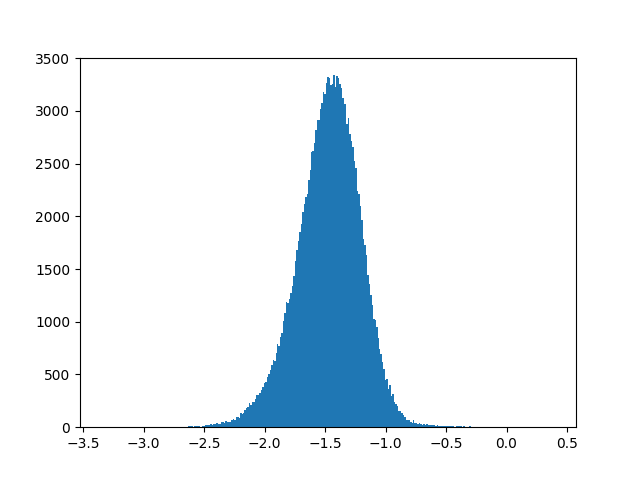

In [50]:
m = numpy.isfinite(clumps_cat["lambda200c"])

plt.figure()
plt.hist(np.log10(clumps_cat["lambda200c"][m]), bins="auto")

plt.show()

In [5]:


clumps_cat["index"][:10]

array([ 1,  2,  3,  5,  6,  7,  9, 11, 12, 13], dtype=int32)

In [6]:
X = csiborgtools.read.load_parent_particles(3, parts, clumpmap0, clid2map0, clumps_cat)

In [29]:
clump = csiborgtools.fits.Clump(X, clumps_cat[2], box)
clumps_cat[2]["index"]

3

In [37]:
clump.spherical_overdensity_mass(200)

(0.0008713664483347365, 1.8111896e-06)

In [26]:
def f(mass):
    return numpy.cumsum(mass)

@jit(nopython=True)
def g(mass):
    return numpy.cumsum(mass)

x  = clump['M']

In [25]:
%timeit f(x)

73.4 µs ± 401 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [28]:
%timeit g(x)

31.8 µs ± 385 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
%timeit clump.spherical_overdensity_mass(200)

3.79 ms ± 47.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


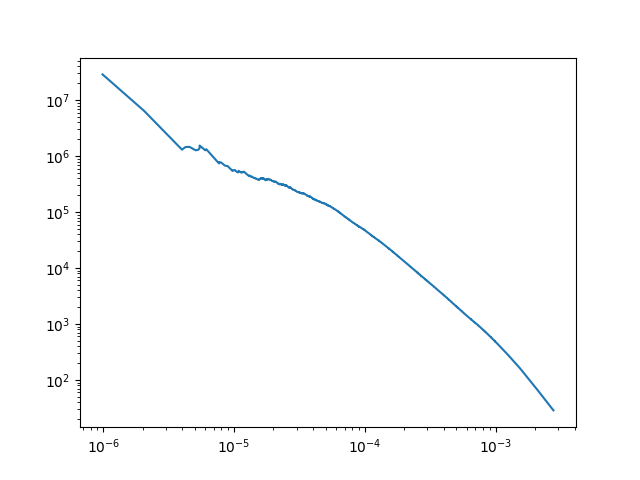

In [14]:
plt.figure()
plt.plot(rs, y)
plt.yscale("log")
plt.xscale("log")
plt.show()

In [16]:
%timeit clump.r()

224 µs ± 4.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [87]:
x, y, z = clump['x'], clump['y'], clump['z']
x0, y0, z0 = clumps_cat[3]['x'], clumps_cat[3]['y'], clumps_cat[3]['z']


In [93]:
%timeit ((x - x0)**2 + (y - y0)**2 + (z - z0)**2)**0.5

145 µs ± 539 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [92]:
%timeit clump.r()

242 µs ± 6.44 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [267]:
delta_bckg *= 2

In [260]:
%timeit delta1, delta2, cellmins, nonzero = overlapper.make_deltas(pos, pos2, mass, mass)
# __ = overlapper.make_deltas(pos, pos2, mass, mass)

1.23 ms ± 6.98 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [271]:
%timeit overlapper(pos, pos2, mass, mass, delta_bckg)

1.75 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


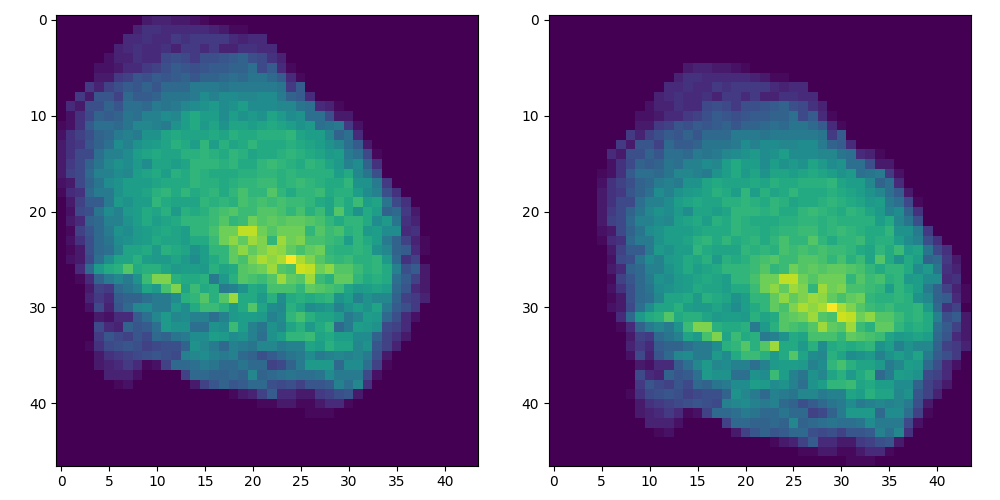

In [259]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
axs[0].imshow(np.sum(delta1, axis=0))
axs[1].imshow(np.sum(delta2, axis=0))
fig.tight_layout()

In [93]:
delta = overlapper.make_bckg_delta(pos, mass / mass)

In [282]:
from functools import cache 
from functools import lru_cache

In [283]:
from time import sleep

@lru_cache(maxsize=1024)
def f(x):
    sleep(0.5)
    return x * x

In [286]:
%timeit f(2)

79 ns ± 0.372 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [77]:
clumpmap0[:]

array([[        0,         0, 277961071],
       [        1, 277961072, 277980356],
       [        2, 277980357, 277985437],
       ...,
       [ 21836472, 460470781, 460470782],
       [ 21836487, 460470783, 460471462],
       [ 21836785, 460471463, 460471466]], dtype=int32)

In [72]:
dens = overlapper.make_delta(pos, mass, subbox=True)

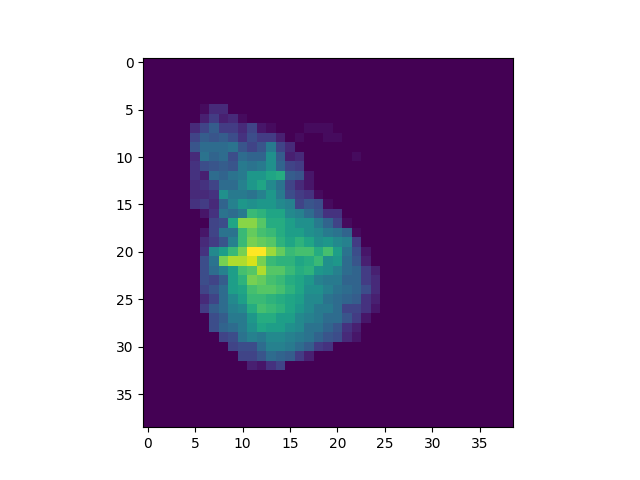

In [55]:
x.shape, x0.shape

((134842, 7), (134842, 4))

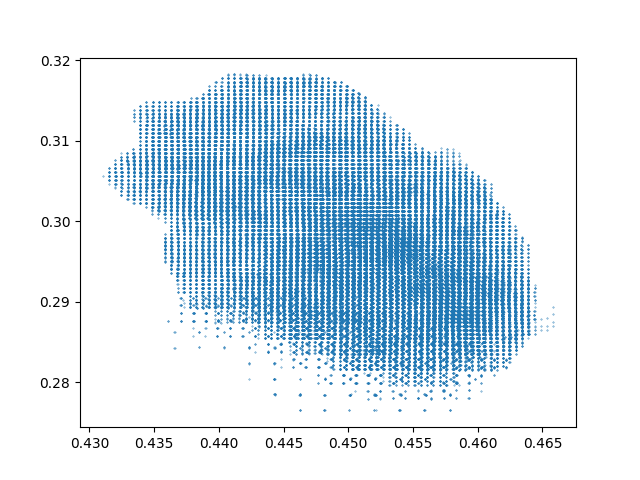

In [56]:
plt.figure()
# plt.scatter(x[:, 0], x[:, 1], s=0.1)
plt.scatter(x0[:, 0], x0[:, 1], s=0.1)

plt.show()

In [11]:
unique_clump_ids = numpy.unique(clump_ids)

In [22]:
unique_clump_ids[:100]

array([  0,   1,   2,   3,   5,   6,   7,   9,  11,  12,  13,  14,  15,
        17,  19,  21,  22,  23,  29,  32,  34,  39,  43, 134, 137, 138,
       139, 149, 151, 156, 157, 158, 159, 161, 163, 165, 167, 168, 169,
       172, 173, 175, 178, 179, 181, 183, 186, 187, 188, 189, 191, 193,
       194, 196, 197, 198, 204, 207, 209, 211, 212, 213, 214, 215, 216,
       217, 218, 221, 223, 225, 227, 228, 231, 232, 237, 238, 240, 243,
       245, 247, 248, 249, 252, 257, 258, 259, 260, 262, 263, 264, 267,
       268, 269, 270, 272, 273, 274, 275, 276, 278], dtype=int32)

In [26]:
%timeit numpy.nan == numpy.nan

131 ns ± 0.529 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [27]:
%timeit numpy.isnan(numpy.nan)

791 ns ± 5.14 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [29]:
test = {"asd": 1}
with h5py.File("test.hp", 'w') as f:
    f.create_dataset("test", data=test)

TypeError: Object dtype dtype('O') has no native HDF5 equivalent

In [ ]:
f

In [23]:
k0, kf = minmax_clump(259, clump_ids)

kf - k0 + 1

2360

In [24]:
clump_ids[k0:kf+1]

array([259, 259, 259, ..., 259, 259, 259], dtype=int32)

In [3]:
import numpy

nsim = nsim0
nsnap = nsnap0


part0 = h5py.File(paths.initmatch_path(nsim, "particles"), 'r')['particles']
cmap = h5py.File(paths.particles_path(nsim, "clumpmap"), 'r')
partf = h5py.File(paths.particles_path(nsim), 'r')["particles"]

In [8]:
part0[cmap[str(558655)], :]

In [5]:
cat = csiborgtools.read.ClumpsCatalogue(nsim, paths, rawdata=True)

In [44]:
from tqdm import tqdm
y = np.zeros((10000, 2), dtype=np.int32)

for i, hid in tqdm(enumerate(cat["index"][cat.ismain][:10000])):
    n = np.sum(cat["parent"] == hid)
    y[i, :] = hid, n

10000it [00:51, 193.86it/s]


In [8]:
cat["index"][cat["parent"] == 558655]

array([558655, 558659, 558673, 558675, 558677, 558692, 558705, 558717,
       558724, 558726, 558739, 558746, 558857, 559232, 559256, 559292,
       559325, 559343, 559349, 559384, 559388, 559406, 559415, 559453,
       559467, 559473, 559492, 559496, 559541, 559544, 559548, 559570,
       559571, 559604, 559612, 559637, 559643, 559648, 559655, 559724,
       559735, 559779, 559780, 559792, 559802, 559804, 559817, 559910,
       559918, 559926, 559960, 559977, 559982, 559997, 560012, 560031,
       560122, 560213, 560325, 560375, 560426, 560517, 560798, 562156,
       563235, 563254, 563586, 563651, 563671, 563892, 564050, 564068,
       564138, 564153, 564358, 564525, 564734, 564745, 564779, 564831,
       565008, 565180, 565272, 565276, 565521, 565620, 565701, 565891,
       566046, 566604, 566705, 567047, 567336, 567720, 568897, 569232,
       569376, 569773, 573130, 575459, 575880, 576414, 579319, 579445,
       579722, 579770, 580117, 580388, 580441, 580507, 580518, 581594,
      

In [45]:
y[np.argmax(y[:, 1]), :]

array([558655,    127], dtype=int32)

In [8]:
keys = list(cmap.keys())

In [11]:

csiborgtools.fits.load_parent_particles(558655, part0, cmap, cat)
# Xf = csiborgtools.fits.load_parent_particles(378, partf, cmap, cat)

[558655 558659 558673 558675 558677 558692 558705 558717 558724 558726
 558739 558746 558857 559232 559256 559292 559325 559343 559349 559384
 559388 559406 559415 559453 559467 559473 559492 559496 559541 559544
 559548 559570 559571 559604 559612 559637 559643 559648 559655 559724
 559735 559779 559780 559792 559802 559804 559817 559910 559918 559926
 559960 559977 559982 559997 560012 560031 560122 560213 560325 560375
 560426 560517 560798 562156 563235 563254 563586 563651 563671 563892
 564050 564068 564138 564153 564358 564525 564734 564745 564779 564831
 565008 565180 565272 565276 565521 565620 565701 565891 566046 566604
 566705 567047 567336 567720 568897 569232 569376 569773 573130 575459
 575880 576414 579319 579445 579722 579770 580117 580388 580441 580507
 580518 581594 581767 582047 582713 583256 586403 587027 587239 588764
 593803 595742 596219 599285 600189 603135 605484]


  0%|          | 0/127 [00:00<?, ?it/s]

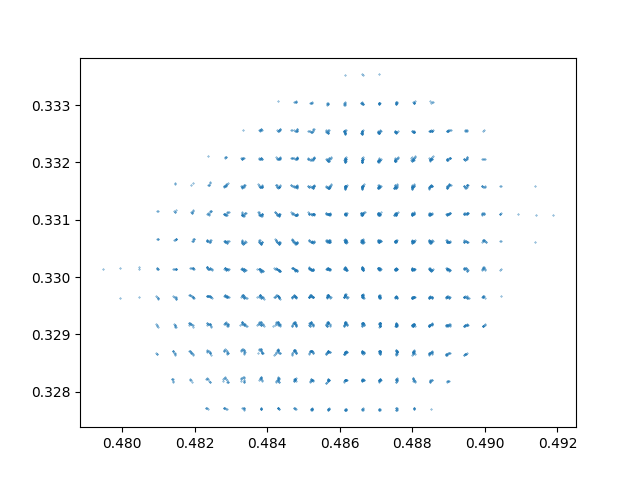

In [6]:
plt.figure()

plt.scatter(X[:, 0], X[:, 1], s=0.1)
# plt.scatter(Xf[:, 0], Xf[:, 1], s=0.1)

plt.show()

In [3]:
pid_final = np.load("pid_final.npy")
pid_init = np.load("pid_initial.npy")

In [4]:
pid_order = np.argsort(pid_final).astype(np.int32)

pid_order_2 = np.argsort(pid_order).astype(np.int32)

In [6]:
# Sort them

pid_init = pid_init[np.argsort(pid_init)]

In [11]:
np.alltrue(pid_init[pid_order_2] == pid_final)

True

array([        6,         7,         8, ..., 429538984, 456581538,
       456482476], dtype=int32)

In [25]:



pid_final[pid_order][pid_order_2]

array([        6,         7,         8, ..., 429538984, 456581538,
       456482476], dtype=int32)

In [18]:
part0['ID']

array([        1,         2,         3, ..., 460357796, 460357797,
       460357798], dtype=int32)

In [8]:
indx1 = numpy.argsort(part0['ID'])

indx2 = numpy.argsort(pid)

indx1_inv = numpy.argsort(indx1)
part0 = part0[indx2][indx1_inv]
# pid = pid[indx2]

In [9]:
part0

array([(0.6463347 , 0.5915494 , 0.3729033 , 1.1641532e-10, 285313656),
       (0.22073722, 0.49019635, 0.9627326 , 5.9604645e-08,  58672855),
       (0.7210556 , 0.18949312, 0.37298316, 5.9604645e-08, 459417395),
       ...,
       (0.46851808, 0.2966002 , 0.44987014, 1.1641532e-10,   2684309),
       (0.7481397 , 0.02954267, 0.8927611 , 5.9604645e-08, 402473389),
       (0.9159686 , 0.8301242 , 0.67392564, 5.9604645e-08, 287235917)],
      dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('M', '<f4'), ('ID', '<i4')])

In [10]:
pid

array([        6,         7,         8, ..., 429538984, 456581538,
       456482476], dtype=int32)

In [6]:
pid

array([        1,         2,         3, ..., 460471465, 460471466,
       460471467], dtype=int32)

In [9]:
cat = csiborgtools.read.ClumpsCatalogue(nsim, paths, load_fitted=False, rawdata=True)
parent_ids = cat["index"][cat.ismain]

parent_ids[:50]

array([  1,   2,   3,   5,   6,   7,   9,  11,  12,  13,  15,  17,  19,
        21,  22,  23,  29,  32,  34,  39, 134, 137, 138, 139, 149, 151,
       156, 157, 158, 159, 161, 163, 167, 168, 169, 172, 173, 175, 178,
       181, 186, 188, 189, 191, 196, 197, 198, 204, 209, 211], dtype=int32)

In [54]:
i = cat["index"][np.argsort(cat["mass_cl"])[::-3][213]]
i

11031538

In [55]:
# clid = 10170336
# clid = 10170336 + 12
clid = i


mmain_indxs = cat["index"][cat["parent"] == clid]
# mask = clump_ids == clid
# print(mask.sum())
print(mmain_indxs)

print([numpy.sum(clump_ids == j) for j in mmain_indxs])


[11031538 11032027 11033906 11034471 11034477 11034692 11035306 11049411
 11057461 11058959]
[24440, 256, 133, 0, 0, 0, 113, 0, 0, 0]


In [56]:
mask = numpy.isin(clump_ids, mmain_indxs)
mask.sum()

24942

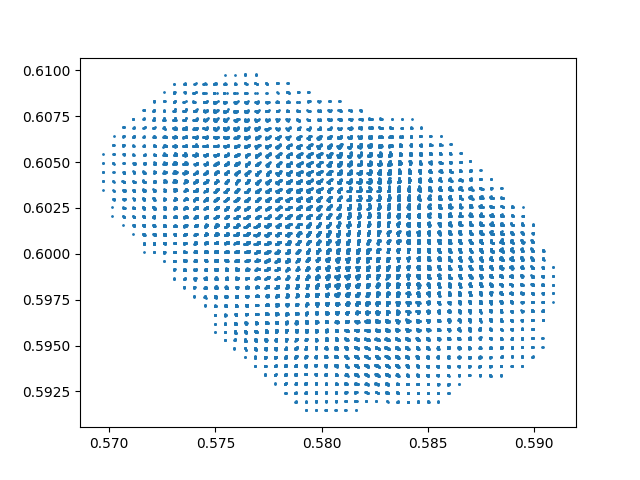

In [57]:
# coords = part0[mask, :]
plt.figure()
plt.scatter(part0['x'][mask], part0['y'][mask], s=1)

plt.show()

In [193]:
particles0 = h5py.File(paths.initmatch_path(nsim0, "particles"), 'r')['particles']
particlesx = h5py.File(paths.initmatch_path(nsimx, "particles") , 'r')['particles']

In [4]:
# delta_bckg = overlapper.make_bckg_delta(particles0, verbose=True)
# delta_bckg = overlapper.make_bckg_delta(particlesx, delta=delta_bckg, verbose=True)
# np.save("./bckg_{}_{}.npy".format(nsim0, nsimx), delta_bckg)
# delta_bckg = np.load("./bckg_{}_{}.npy".format(nsim0, nsimx))

In [194]:
map0 = h5py.File(paths.initmatch_path(nsim0, "halomap"), 'r')
mapx = h5py.File(paths.initmatch_path(nsimx, "halomap"), 'r')

In [174]:
keys = np.array(sorted([int(x) for x in mapx.keys()]))

In [175]:
paths = csiborgtools.read.CSiBORGPaths(**csiborgtools.paths_glamdring)

halocat = csiborgtools.read.HaloCatalogue(nsimx, paths, rawdata=True)
clumpcat = csiborgtools.read.ClumpsCatalogue(nsimx, paths, rawdata=True)

In [176]:
clid = 2


np.sum(clumpcat["parent"] == clid)

# mmain_indxs = clumpcat["index"][clumpcat["parent"] == clid]

# mmain_indxs
# mmain_mask = numpy.isin(clump_ids, mmain_indxs, assume_unique=True)

10

In [195]:
fs = list(map0.keys())

In [196]:
from tqdm import tqdm
tot = 0
for f in tqdm(fs):
    tot += map0[f].shape[0]

print(tot)

100%|██████████| 173643/173643 [01:29<00:00, 1947.49it/s]

362439022


In [197]:
particles0

<HDF5 dataset "particles": shape (182510395, 4), type "<f4">

In [198]:
tot / 182510395

1.9858541317605498

In [172]:
particlesx

<HDF5 dataset "particles": shape (182036133, 4), type "<f4">

In [177]:
i = 10170336


k = np.where(cat["ID"] == i)[0][0]
k

86031

In [178]:
# i = np.random.choice(keys[keys<100000])

# # i = 10040155 #+ 11

print(i)
# i = 32


mask = map0[str(i)]
mask

10170336


<HDF5 dataset "10170336": shape (2085,), type "<i8">

In [183]:
halo = particlesx[mask, :]

In [184]:
np.sum(halo[:, 3]) / 1.1641532e-10

2085.000032720428

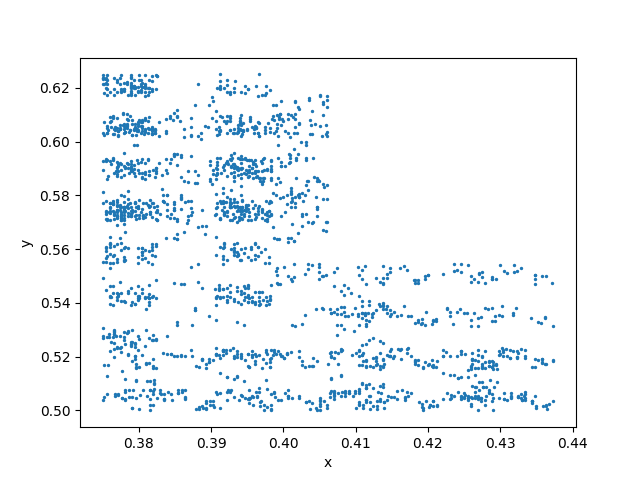

In [186]:
plt.figure()
plt.scatter(halo[:, 0], halo[:, 1], s=2)
# plt.scatter(cat['x'][k], cat['y'][k], s=10, c='r')

plt.xlabel(r"x")
plt.ylabel(r"y")

plt.show()

/tmp/ipykernel_7442/2249068321.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.sum(delta_bckg, axis=0)))


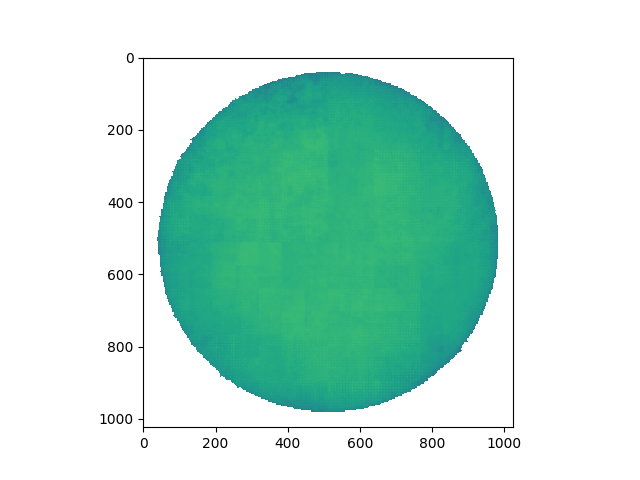

In [21]:
plt.figure()
plt.imshow(np.log10(np.sum(delta_bckg, axis=0)))
plt.show()

In [2]:
f = h5py.File("../data/particles_7444.h5", "r")

In [8]:
f["particles"][0, :]

array([ 4.42346358e-01,  7.09757663e-03,  4.64053304e-01, -1.96926287e-03,
       -2.67177823e-03, -6.45721859e-04,  1.16415322e-10])